# Customer Churn

A Client is Beta-Bank, which faced an issue of customers leaving the bank: on a regular basis, little amount, but noticeable. Banking marketers figured it was cheaper to keep current customers than to attract new ones.

The aim is to predict whether the client will leave the bank in the near future or not. 
Data - is historical data on customer behavior and termination of agreements with the bank.

The measure for a model is *F1*-measure. The metric should be at least 0.59. Additionally, measure *AUC-ROC* needs to be found and compared to the value of *F1*-measure.

## 1. Data preprocessing

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
data = pd.read_csv('/datasets/Churn.csv')
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   RowNumber        10000 non-null  int64  
 1   CustomerId       10000 non-null  int64  
 2   Surname          10000 non-null  object 
 3   CreditScore      10000 non-null  int64  
 4   Geography        10000 non-null  object 
 5   Gender           10000 non-null  object 
 6   Age              10000 non-null  int64  
 7   Tenure           9091 non-null   float64
 8   Balance          10000 non-null  float64
 9   NumOfProducts    10000 non-null  int64  
 10  HasCrCard        10000 non-null  int64  
 11  IsActiveMember   10000 non-null  int64  
 12  EstimatedSalary  10000 non-null  float64
 13  Exited           10000 non-null  int64  
dtypes: float64(3), int64(8), object(3)
memory usage: 1.1+ MB


,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2.0,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1.0,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8.0,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1.0,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2.0,125510.82,1,1,1,79084.10,0


The dataset consists of 14 columns and 10,000 rows. 
The following transformations are offered to the data: <br/>
1) There are gaps in the `Tenure` column. It is proposed to analyze these gaps and subsequently replace or remove them; <br/>
2) The columns `RowNumber`, `CustomerId` and `Surname` do not affect the construction of the model, because they do not carry quality information for training of the model, so they can be excluded from the dataset; <br/>
3) 3 columns have object data type. To transform the data of categorical variables for further training of the model, it is proposed to use the technique of direct coding (One-Hot Encoding (OHE)); <br/>
4) It can be also observed, that first 5 lines have quantitative data of different dimensions (eg `Age` (Age) and `Balance` (balance on the card)). To bring the data to the same scale, it is proposed to standardize it using the StandardScaler structure, **preliminarily dividing the samples into training, validation and test**; <br/>
5) Also, the features will be analyzed for multicollinearity and if there is a high correlation, the features will be adjusted for linear models.

Median Tenure: 5.0
Mean Tenure: 4.997690023099769
Correlation Tenure with Age, Balance, CreditScore: -0.013134384930796541 -0.007910697992078466 -6.170339999155625e-05


<AxesSubplot:ylabel='Frequency'>

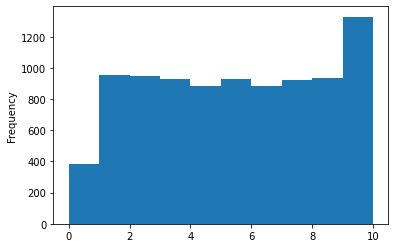

In [3]:
print('Median Tenure:', data['Tenure'].median())
print('Mean Tenure:', data['Tenure'].mean())
print('Correlation Tenure with Age, Balance, CreditScore:', data['Tenure'].corr(data['Age']), data['Tenure'].corr(data['Balance']), data['Tenure'].corr(data['CreditScore']))
data['Tenure'].plot(kind='hist')

The correlation of Tenure with other parameters is weak, the mean and median are close to 5. At the same time, the data is distributed evenly, with a slight increase towards the value of 10. In order to avoid data distortion, distribution distortion, it is proposed to remove rows with gaps in `Tenure`.

In [4]:
#columns and gaps dropping
data=data.dropna(axis=0)
data = data.drop(['CustomerId', 'Surname', 'RowNumber'], 1)
data.columns

Index(['CreditScore', 'Geography', 'Gender', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary',
       'Exited'],
      dtype='object')

In [5]:
features = data.drop('Exited', 1)
target = data['Exited']

<AxesSubplot:>

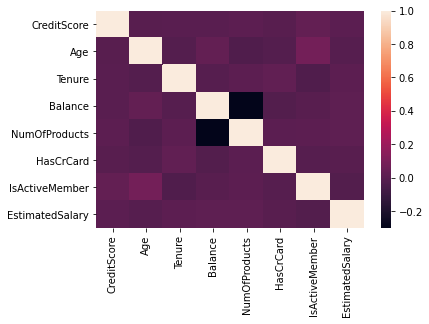

In [6]:
#multicollinearity check
corr_matrix = features.corr()
sn.heatmap(corr_matrix)

The correlation between the parameters is weak, multicollinearity is not observed.

In [7]:
#OHE coding
features=pd.get_dummies(features, drop_first=True)
features.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9091 entries, 0 to 9998
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   CreditScore        9091 non-null   int64  
 1   Age                9091 non-null   int64  
 2   Tenure             9091 non-null   float64
 3   Balance            9091 non-null   float64
 4   NumOfProducts      9091 non-null   int64  
 5   HasCrCard          9091 non-null   int64  
 6   IsActiveMember     9091 non-null   int64  
 7   EstimatedSalary    9091 non-null   float64
 8   Geography_Germany  9091 non-null   uint8  
 9   Geography_Spain    9091 non-null   uint8  
 10  Gender_Male        9091 non-null   uint8  
dtypes: float64(3), int64(5), uint8(3)
memory usage: 665.8 KB


In [8]:
#60/20/20 split for training, validation and test samples
features_train_1, features_test, target_train_1, target_test = train_test_split(features, target, test_size=0.2, random_state=12345)  
features_train, features_valid, target_train, target_valid = train_test_split(features_train_1, target_train_1, test_size=0.25, random_state=12345)

display(features_train.shape) 
display(features_test.shape) 
features_valid.shape #check

(5454, 11)

(1819, 11)

(1818, 11)

In [9]:
#scaling
columns = ['CreditScore', 'Age', 'Balance', 'Tenure', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
scaler = StandardScaler()
scaler.fit(features_train[columns])
features_train[columns]=scaler.transform(features_train[columns])
features_test[columns]=scaler.transform(features_test[columns])
features_valid[columns]=scaler.transform(features_valid[columns])
display(features_train.head())

/tmp/ipykernel_86/45277902.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features_train[columns]=scaler.transform(features_train[columns])
/opt/conda/lib/python3.9/site-packages/pandas/core/indexing.py:1738: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
/tmp/ipykernel_86/45277902.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
3706,-0.203819,0.471273,0.352316,0.786022,0.782369,-1.545860,-1.016640,-0.357205,0,1,0
6805,-0.357513,-0.384930,-1.373506,-1.230577,0.782369,0.646889,0.983632,-1.671048,0,0,0
4449,0.175290,-0.289797,-0.683177,-1.230577,0.782369,0.646889,-1.016640,-1.119181,0,0,1
598,0.349476,1.708010,0.007151,1.379462,-0.914942,-1.545860,-1.016640,-1.569064,1,0,0
1845,0.902771,-0.289797,1.387809,-1.230577,-0.914942,-1.545860,0.983632,1.543790,0,0,1


### Conclusion
Data was preprocessed for the further models building at the first step.

## 2. Task research

At the second step, models will be built without using class balancing and F1 and AUC-ROC metrics will be calculated. For the task research, the max_depth parameter for the DecisionTreeClassifier and RandomForestClassifier models will be set to 8.

In [10]:
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Logistic Regression w/o balanced class weight', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Logistic Regression w/o balanced class weight 0.3004115226337448
Auc-Roc 0.7725917897303888


In [11]:
model = DecisionTreeClassifier(random_state=12345, max_depth=8)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Tree w/o balanced class weight', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Tree w/o balanced class weight 0.5328947368421052
Auc-Roc 0.8216658010808532


In [12]:
model = RandomForestClassifier(random_state=12345, max_depth=8)
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Random Forest w/o balanced class weight', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Random Forest w/o balanced class weight 0.5444839857651246
Auc-Roc 0.8517100964940012


### Conclusion
The models were trained without taking into account class balancing at the second step. The F1 metric reached the maximum value of 0.5329 on the decision tree.

## 3. Solutions for class imbalance 

To improve the quality of the models, it is proposed to use class weighting and upsampling. Also, during the selection of the best model in the decision tree and random forest, it is proposed to enumerate the max_depth and n_estimators parameters.

In [13]:
model = LogisticRegression(random_state=12345, solver='liblinear', class_weight='balanced')
model.fit(features_train, target_train)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Logistic Regression with balanced class weight', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Logistic Regression with balanced class weight 0.49458128078817737
Auc-Roc 0.7747651628054014


In [14]:
for depth in range (6, 11, 1):
    model = DecisionTreeClassifier(max_depth=depth, random_state=12345, class_weight='balanced')
    model.fit(features_train, target_train)
    predicted_valid = model.predict(features_valid)
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    print('Depth=', depth, 'F1 Tree with balanced class weight', f1_score(target_valid, predicted_valid))
    print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

Depth= 6 F1 Tree with balanced class weight 0.5533262935586061
Auc-Roc 0.810823397913562
Depth= 7 F1 Tree with balanced class weight 0.5555555555555556
Auc-Roc 0.8150158439838022
Depth= 8 F1 Tree with balanced class weight 0.552863436123348
Auc-Roc 0.7968366601935901
Depth= 9 F1 Tree with balanced class weight 0.5387205387205386
Auc-Roc 0.774092452091707
Depth= 10 F1 Tree with balanced class weight 0.5345016429353778
Auc-Roc 0.7623731728612504


In [15]:
for est in  range (60, 100, 10):
    for depth in range (7, 11, 1):
        model = RandomForestClassifier(n_estimators=est, max_depth=depth, random_state=12345, class_weight='balanced')
        model.fit(features_train, target_train)
        predicted_valid = model.predict(features_valid)
        probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
        print('Est=', est, 'Depth=', depth, 'F1 Random forest with balanced class weight', f1_score(target_valid, predicted_valid))
        print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

Est= 60 Depth= 7 F1 Random forest with balanced class weight 0.5854241338112306
Auc-Roc 0.8480614641195864
Est= 60 Depth= 8 F1 Random forest with balanced class weight 0.5957446808510637
Auc-Roc 0.8509498863448193
Est= 60 Depth= 9 F1 Random forest with balanced class weight 0.5978552278820376
Auc-Roc 0.8485300094838097
Est= 60 Depth= 10 F1 Random forest with balanced class weight 0.6005665722379604
Auc-Roc 0.8433346128949706
Est= 70 Depth= 7 F1 Random forest with balanced class weight 0.5899280575539568
Auc-Roc 0.8471902331812914
Est= 70 Depth= 8 F1 Random forest with balanced class weight 0.5957446808510637
Auc-Roc 0.8516423549955591
Est= 70 Depth= 9 F1 Random forest with balanced class weight 0.5879194630872484
Auc-Roc 0.8493523160065634
Est= 70 Depth= 10 F1 Random forest with balanced class weight 0.5925925925925926
Auc-Roc 0.8450507308554999
Est= 80 Depth= 7 F1 Random forest with balanced class weight 0.5837320574162679
Auc-Roc 0.8472297490553824
Est= 80 Depth= 8 F1 Random forest w

The F1 metric of 0.59 is reached with the RandomForestClassifier model with **n_estimators = 70** and **max_depth values from 7 to 10**. The approach to increase the sample will be considered below with the same arguments for the RandomForestClassifier model and with  max_depth = 7 in the DecisionTreeClassifier model.

In [16]:
def upsample(features, target, repeat):
    features_zeros = features[target == 0]
    features_ones = features[target == 1]
    target_zeros = target[target == 0]
    target_ones = target[target == 1]

    features_upsampled = pd.concat([features_zeros] + [features_ones] * repeat)
    target_upsampled = pd.concat([target_zeros] + [target_ones] * repeat)
    
    features_upsampled, target_upsampled = shuffle(
        features_upsampled, target_upsampled, random_state=12345)
    
    return features_upsampled, target_upsampled

features_upsampled, target_upsampled = upsample(features_train, target_train, 5)
model = LogisticRegression(random_state=12345, solver='liblinear')
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Logistic regression with upsampling', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Logistic regression with upsampling 0.478920741989882
Auc-Roc 0.7749345165515062


In [17]:
model =  DecisionTreeClassifier(max_depth=7, random_state=12345)
model.fit(features_upsampled, target_upsampled)
predicted_valid = model.predict(features_valid)
probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
print('F1 Tree with upsampling', f1_score(target_valid, predicted_valid))
print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

F1 Tree with upsampling 0.5425742574257426
Auc-Roc 0.8166275271342335


In [18]:
for depth in range (7, 11, 1):
    model = RandomForestClassifier(n_estimators=70, max_depth=depth, random_state=12345)
    model.fit(features_upsampled, target_upsampled)
    predicted_valid = model.predict(features_valid)
    probabilities_one_valid = model.predict_proba(features_valid)[:, 1]
    print('Depth=', depth, 'F1 Random forest with upsampling', f1_score(target_valid, predicted_valid))
    print('Auc-Roc', roc_auc_score(target_valid, probabilities_one_valid))

Depth= 7 F1 Random forest with upsampling 0.57736240913811
Auc-Roc 0.8516103659546281
Depth= 8 F1 Random forest with upsampling 0.5897435897435898
Auc-Roc 0.8513299914194102
Depth= 9 F1 Random forest with upsampling 0.5859030837004405
Auc-Roc 0.8496176368754609
Depth= 10 F1 Random forest with upsampling 0.5969447708578144
Auc-Roc 0.8510684339670926


### Conclusion
The F1 metric is maximized in the RandomForestClassifier model with the parameters n_estimators = 90, max_depth = 9, taking into account class weighting. It is proposed to use this model for the test.

## 4. Model test

F1 test sample 0.6102564102564102
Auc-Roc 0.8574656574151949


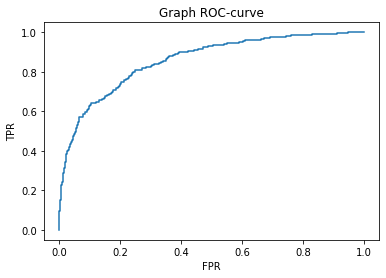

In [19]:
model = RandomForestClassifier(n_estimators=90, max_depth=9, random_state=12345, class_weight='balanced')
model.fit(features_train, target_train)
predicted_test = model.predict(features_test)
probabilities_one_test = model.predict_proba(features_test)[:, 1]
print('F1 test sample', f1_score(target_test, predicted_test))
print('Auc-Roc', roc_auc_score(target_test, probabilities_one_test))
fpr, tpr, _ = roc_curve(target_test, probabilities_one_test)
plt.plot(fpr, tpr)
plt.ylabel('TPR')
plt.xlabel('FPR')
plt.title('Graph ROC-curve')
plt.show()

### Conclusion
Thus, during the study, the data of the original dataset was transformed by removing irrelevant features, scaling quantitative and transforming categorical variables. Further, in the course of the study, a search for the model with the best value of the F1 metric on the validation sample was conducted. The random forest model was chosen as the final model. The value of the F1-measure on the test set reached 0.61, the Auc-Roc metric reached 0.86. The closer the Auc-Roc metric is to 1, the better the predictions of the classification model. At the same time, the more the ROC curve covers the upper left corner of the graph, the better the model classifies the data into categories, which is observed on the graph.